I compared the sentiment scores of the JoeBiden and realDonaldTrump
twitter feeds. It seems that if anything, Biden is more neutral whereas Trump
falls into negative or positive polarisation more often. Trump seems to be
especially more positive in the upper quartile of the pos distribution.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import biokit.viz as bviz
import heatmap
import matplotlib
import matplotlib.pyplot as plt
from src.data.reader import TwitterReader, CSSEReader
from src.utils.statistics import correlation_matrix
from src.visualization.visualize import correlation_matrix_plot
sns.set(style='ticks', context='notebook')

matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['figure.figsize'] = (12, 6)

In [2]:
FIGPATH = "../reports/figures/short_presentation"

Biden

In [3]:
reader = TwitterReader(dirname='twitter_user')
d = reader.read_sentiments()
biden = d['JoeBiden']

# smooth
window = "3d"
win_type = None
biden_mean = biden.rolling(window=window, center=False, win_type=win_type).mean()
biden_sd = biden.rolling(window=window, center=False, win_type=win_type).std()

/Users/felix/miniconda3/envs/bd4pp/lib/python3.7/site-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11d3ef390>,
      dtype=object)

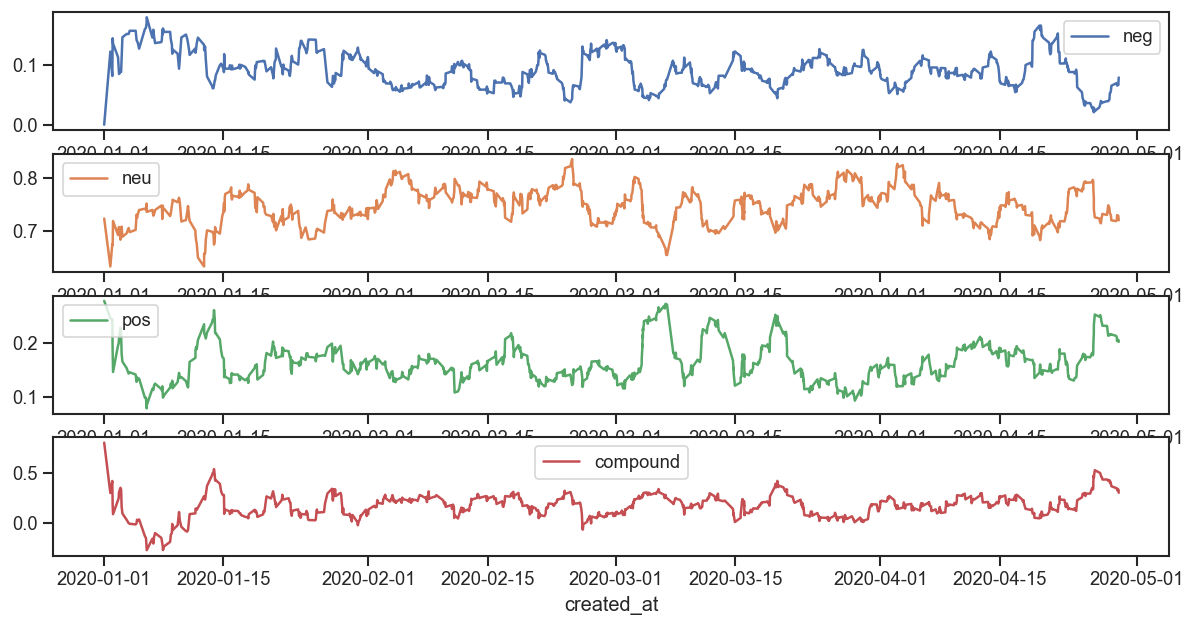

In [4]:
# plot
fig, ax = plt.subplots(figsize=(12,6))
#biden.plot(yerr=biden_sd, capsize=4,capthick=1, subplots=True, ax=ax)
biden_mean.plot(subplots=True, ax=ax)

Trump

/Users/felix/miniconda3/envs/bd4pp/lib/python3.7/site-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11b2fc7d0>,
      dtype=object)

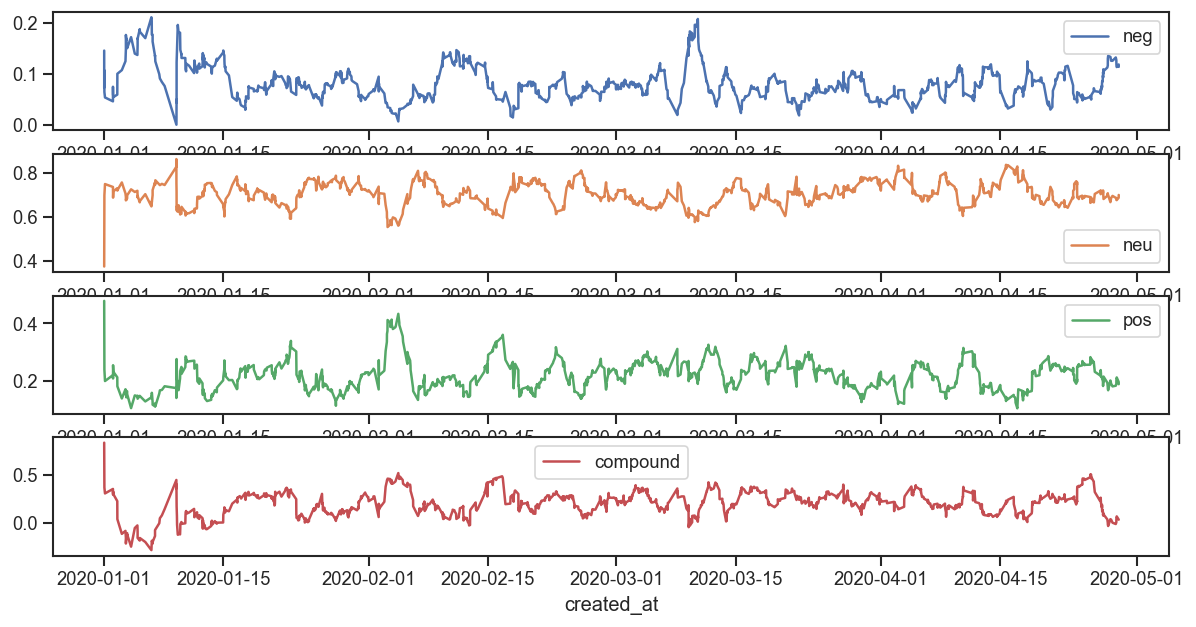

In [5]:
reader = TwitterReader(dirname='twitter_user')
d = reader.read_sentiments()
trump = d['realDonaldTrump']

# smooth
window = "2d"
trump_mean = trump.rolling(window=window, center=False).mean()
trump_sd = trump.rolling(window=window, center=False).std()

# plot
fig, ax = plt.subplots(figsize=(12,6))
#biden.plot(yerr=biden_sd, capsize=4,capthick=1, subplots=True, ax=ax)
trump_mean.plot(subplots=True, ax=ax)

Violinplots of sentiment score distribution

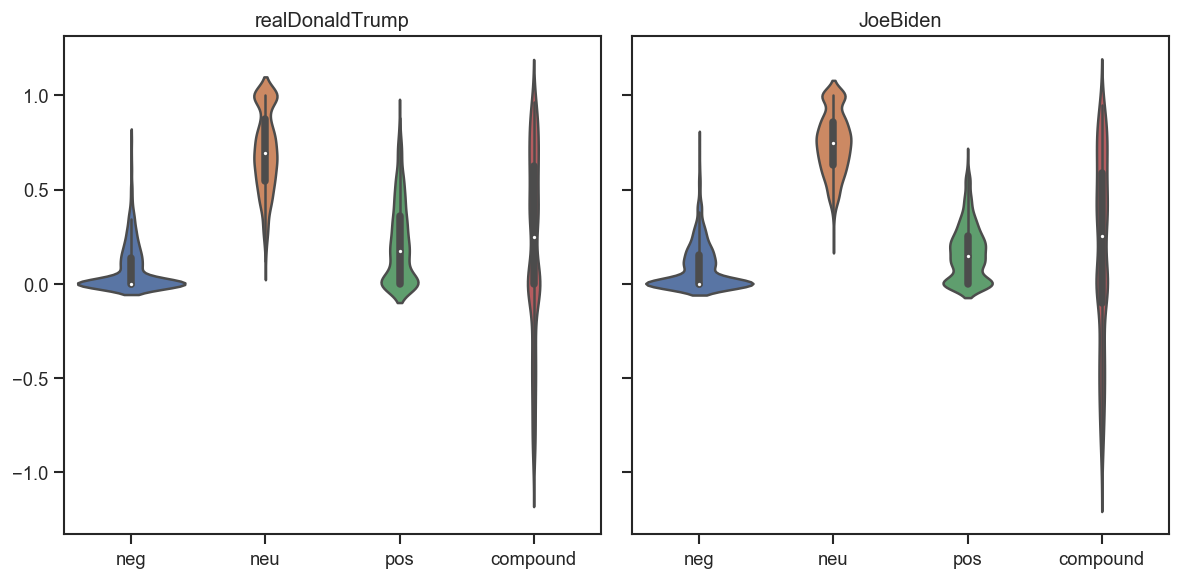

In [6]:
f, axes = plt.subplots(1, 2, figsize=(10,5), sharey=True)

sns.violinplot(data=trump, ax=axes[0])
axes[0].set_title("realDonaldTrump")

sns.violinplot(data=biden, ax=axes[1])
axes[1].set_title("JoeBiden")

plt.tight_layout()
plt.savefig(os.path.join(FIGPATH, 'violinplot_twitter_users.png'),
            dpi=300, format='png')

In [7]:
print("Trump\n", trump.describe())
print("\nBiden\n", biden.describe())

Trump
                neg          neu          pos     compound
count  1521.000000  1521.000000  1521.000000  1521.000000
mean      0.080657     0.701133     0.218211     0.198887
std       0.124450     0.214283     0.216630     0.491720
min       0.000000     0.120000     0.000000    -0.957100
25%       0.000000     0.545000     0.000000     0.000000
50%       0.000000     0.694000     0.176000     0.250000
75%       0.139000     0.874000     0.361000     0.624900
max       0.765000     1.000000     0.880000     0.964300

Biden
                neg          neu          pos     compound
count  1052.000000  1052.000000  1052.000000  1052.000000
mean      0.088340     0.746804     0.164858     0.179285
std       0.120985     0.161908     0.148596     0.492022
min       0.000000     0.244000     0.000000    -0.965700
25%       0.000000     0.629000     0.000000    -0.102700
50%       0.000000     0.749500     0.147000     0.256050
75%       0.154000     0.861250     0.254250     0.585900

Read JHU CSSE data

In [8]:
csse = CSSEReader('csse')
csse_data = csse.read_processed_nc()
csse_us = csse_data.sum(dim='county')

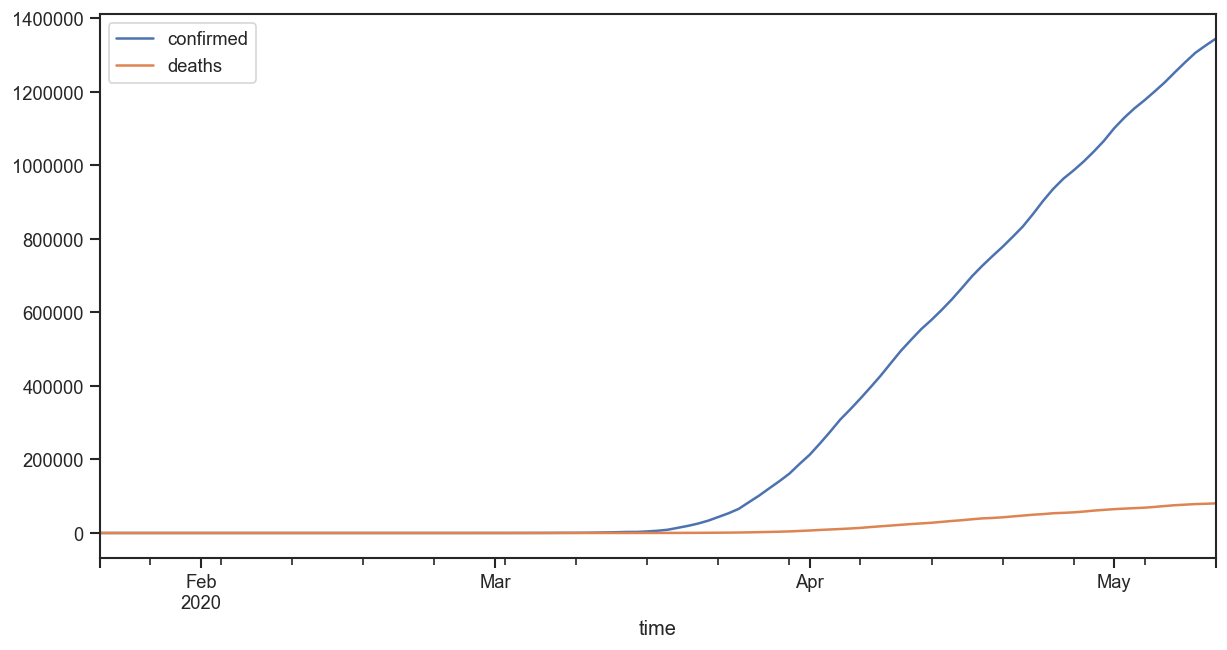

In [9]:
df_csse = csse_us.to_dataframe()
df_csse.plot(subplots=False)

Calculate derivatives of deaths and infections

In [10]:
df_csse['confirmed_d1'] = np.gradient(df_csse['confirmed'].values)
df_csse['deaths_d1'] = np.gradient(df_csse['deaths'].values)

df_csse['confirmed_d2'] = np.gradient(df_csse['confirmed_d1'].values)
df_csse['deaths_d2'] = np.gradient(df_csse['deaths_d1'].values)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12921c5d0>,
      dtype=object)

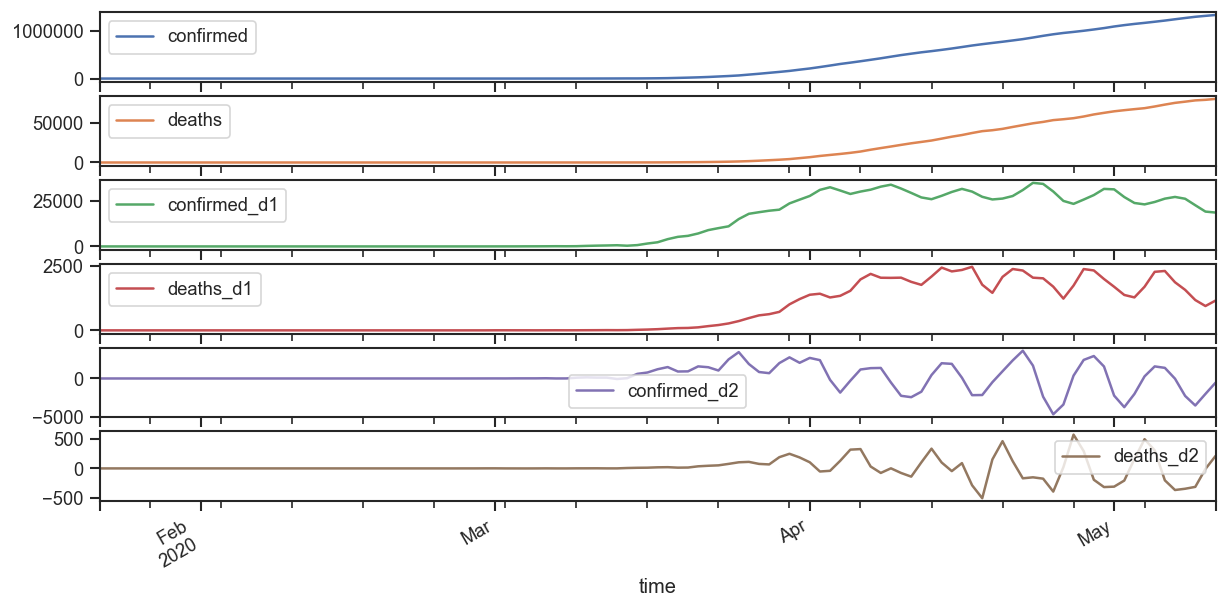

In [11]:
df_csse.plot(subplots=True, figsize=(12,6))

Smoothing experiments

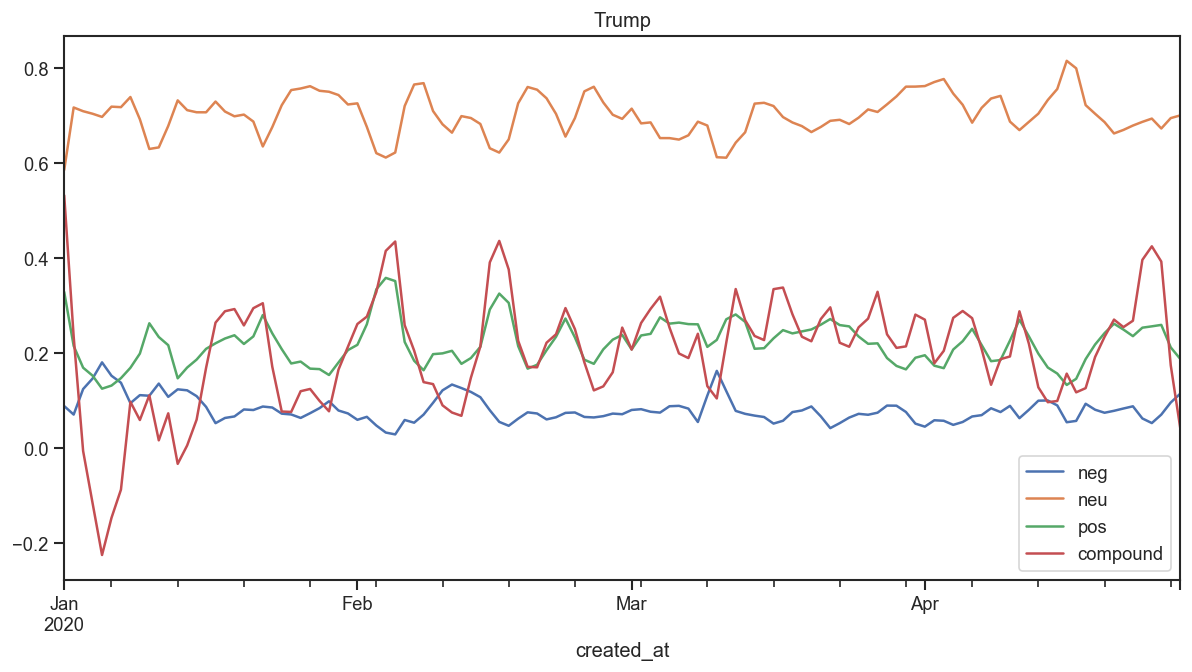

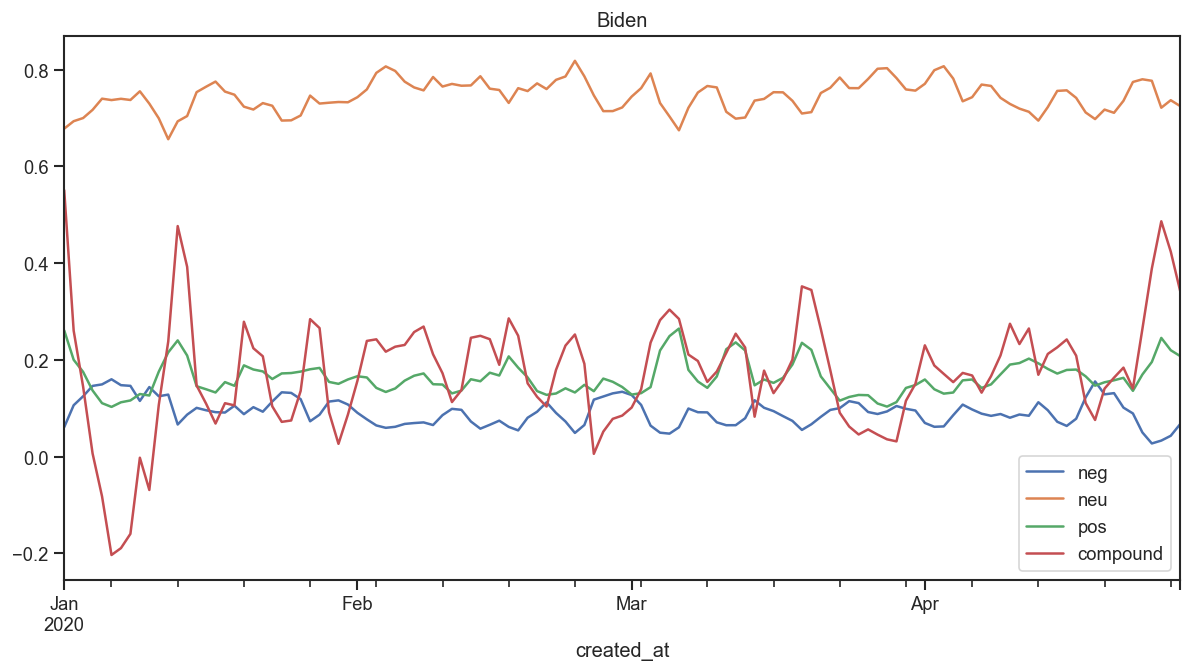

In [12]:
window = "3d"

# trump
trump_mean = trump.rolling(window=window, center=False).mean()
trump_daily = trump_mean.resample('D').mean()
trump_daily.plot(figsize=(12,6), title='Trump')

# biden
biden_mean = biden.rolling(window=window, center=False).mean()
biden_daily = biden_mean.resample('D').mean()
biden_daily.plot(figsize=(12,6), title='Biden')

Merge CSSE and twitter data

In [13]:
#df_csse['tstamps'] = df_csse.index
#trump_daily['tstamps'] = trump_daily.index
#biden_daily['tstamps'] = biden_daily.index

# name indices
trump_daily.index.name = 'time'
biden_daily.index.name = 'time'
df_csse.index.name = 'time'

# remove timezone information
trump_daily.index = trump_daily.index.tz_localize(None)
biden_daily.index = biden_daily.index.tz_localize(None)


In [14]:
csse_trump_merged = pd.merge(trump_daily, df_csse, how='outer', left_index=True, right_index=True)
csse_biden_merged = pd.merge(biden_daily, df_csse, how='outer', left_index=True, right_index=True)


Time series plots of merged data

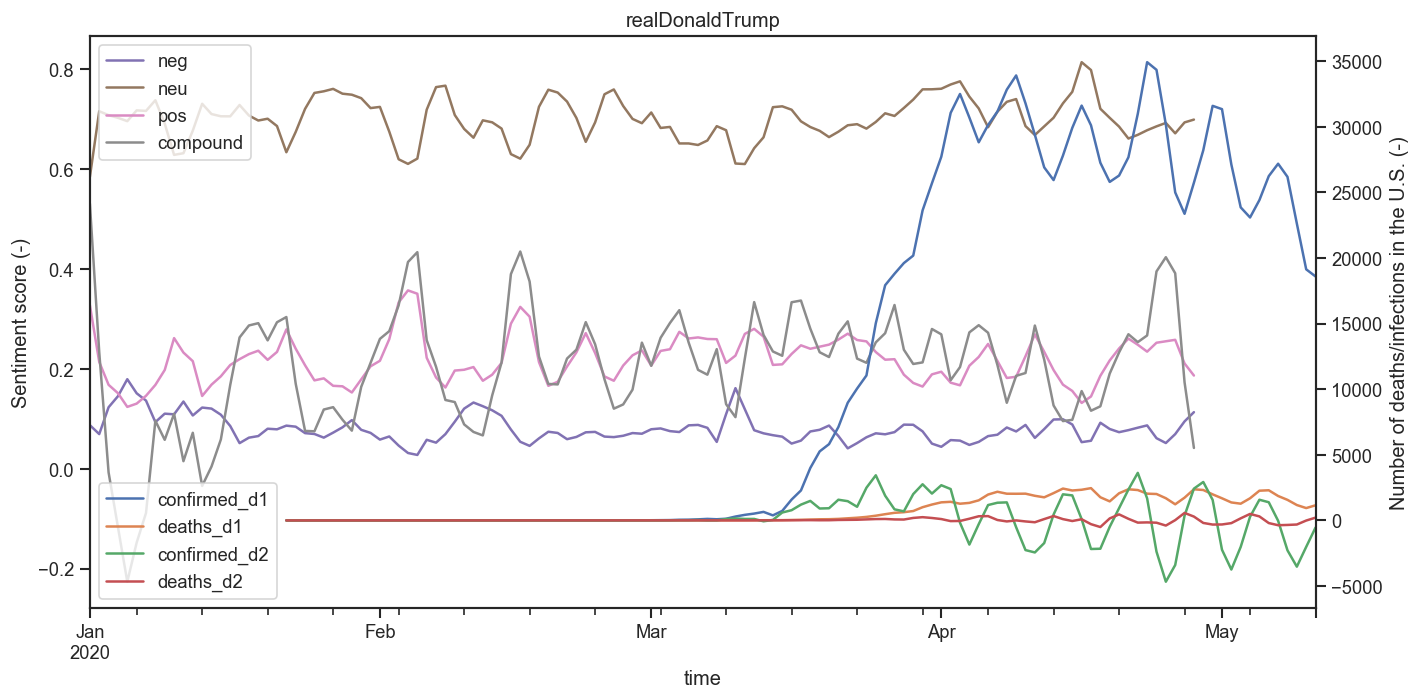

In [15]:
ax = csse_trump_merged[['confirmed_d1', 'deaths_d1', 'confirmed_d2',
                          'deaths_d2', 'neg', 'neu', 'pos', 'compound']].plot(
    secondary_y=['confirmed_d1', 'deaths_d1', 'confirmed_d2', 'deaths_d2'])

ax.legend(loc='upper left')
ax.right_ax.legend(loc='lower left')

ax.set_ylabel('Sentiment score (-)')
ax.right_ax.set_ylabel('Number of deaths/infections in the U.S. (-)')

plt.title('realDonaldTrump')
plt.tight_layout()
plt.savefig(os.path.join(FIGPATH, 'timeseries_realDonaldTrump.png'),
            dpi=300, format='png')

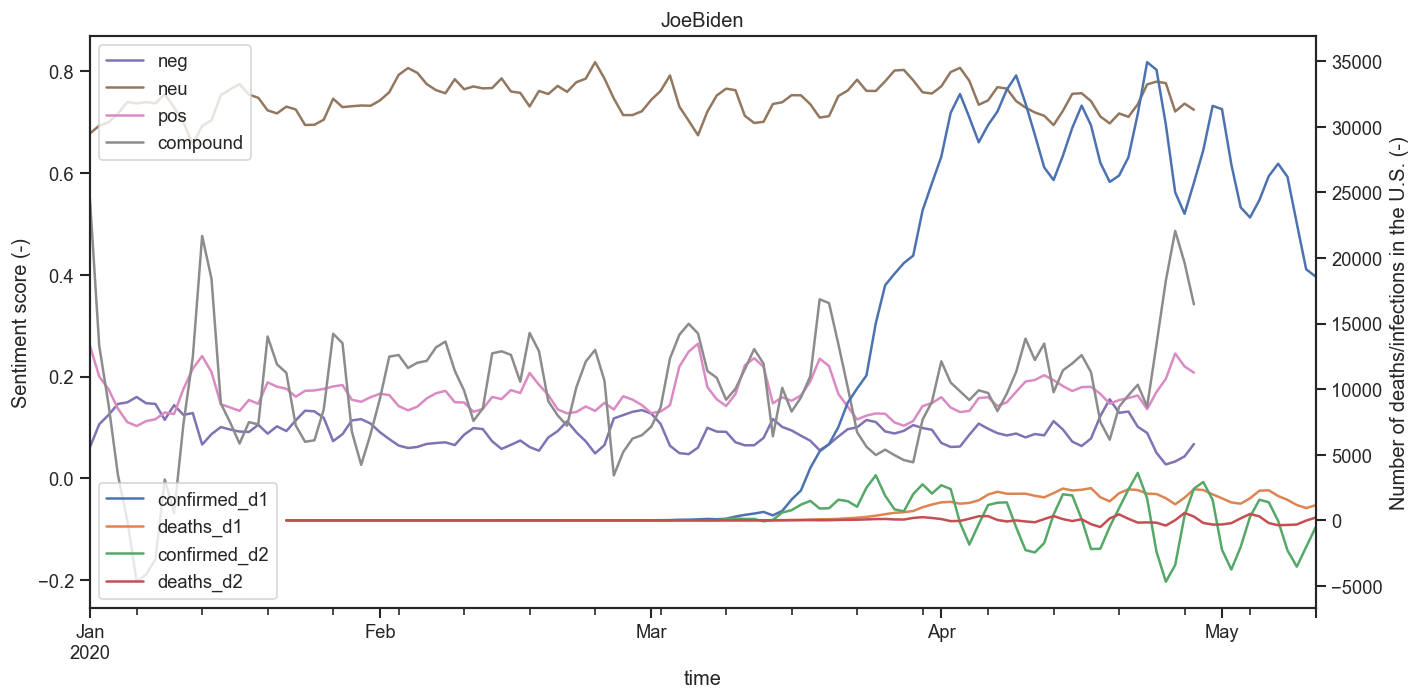

In [16]:
ax = csse_biden_merged[['confirmed_d1', 'deaths_d1', 'confirmed_d2',
                          'deaths_d2', 'neg', 'neu', 'pos', 'compound']].plot(
    secondary_y=['confirmed_d1', 'deaths_d1', 'confirmed_d2', 'deaths_d2'])

ax.legend(loc='upper left')
ax.right_ax.legend(loc='lower left')

ax.set_ylabel('Sentiment score (-)')
ax.right_ax.set_ylabel('Number of deaths/infections in the U.S. (-)')

plt.title('JoeBiden')
plt.tight_layout()
plt.savefig(os.path.join(FIGPATH, 'timeseries_JoeBiden.png'),
            dpi=300, format='png')

Correlation analysis

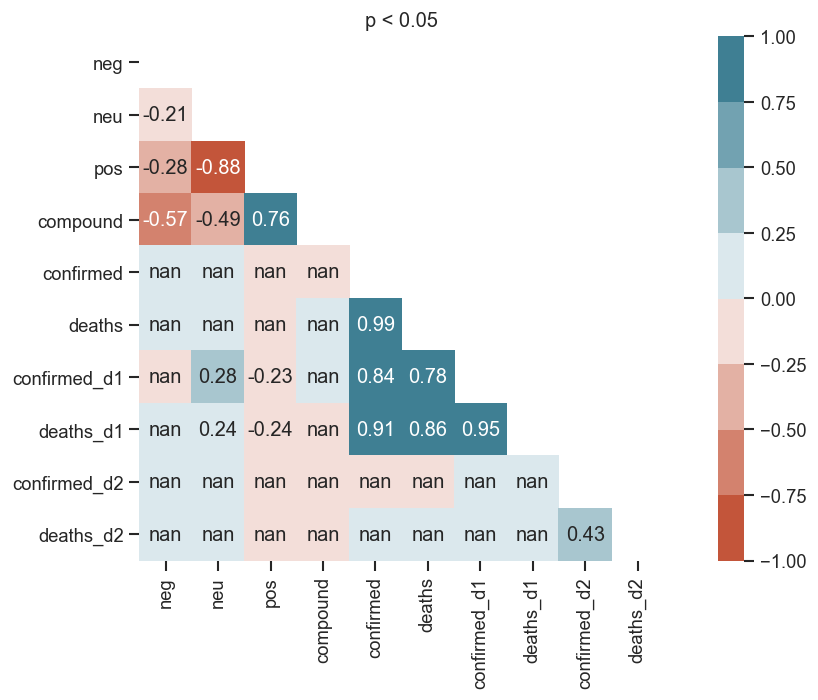

In [17]:
# Trump
correlation_matrix_plot(csse_trump_merged)
plt.savefig(os.path.join(FIGPATH, 'corrplot_realDonaldTrump.png'),
            dpi=300, format='png', bbox_inches='tight')

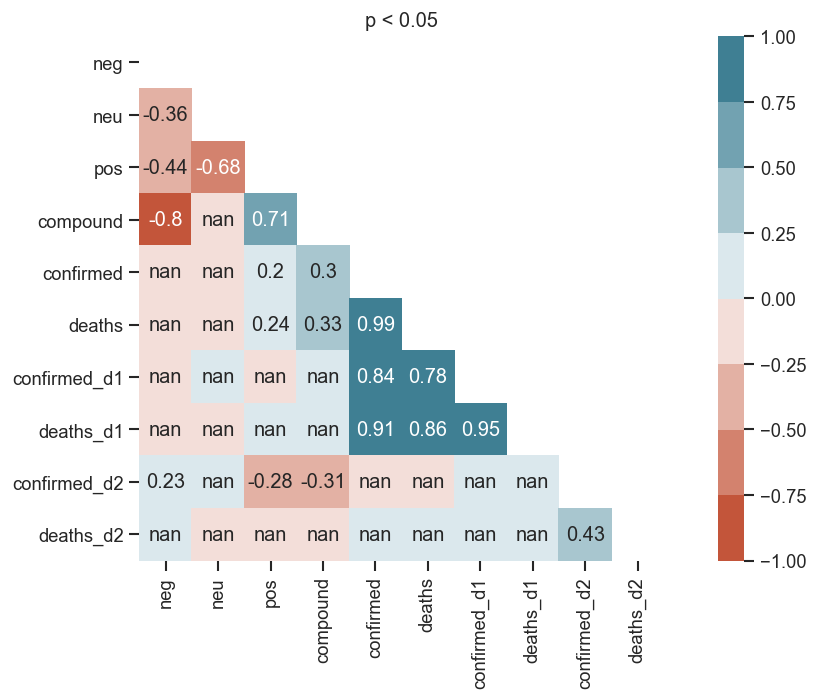

In [18]:
# Biden
correlation_matrix_plot(csse_biden_merged)
plt.savefig(os.path.join(FIGPATH, 'corrplot_JoeBiden.png'),
            dpi=300, format='png', bbox_inches='tight')